## Before run

```
# create a python virtualenv for separating the dependencies
virtualenv virtualenv

# enter the virtualenv
source virtualenv/bin/activate

# install the dependencies
pip install -r requirements.txt
```

Please run the first frame.

NOTE: For brevity, a lot of the helper code is placed in the files `feature_categorization` and `data_preprocessing`. This has been done to avoid a looong file with a lot of util functions values. If you wish to see the file with all of the placeholder functions, see `submission_verbose.ipynb` instead.

# First, check that the dataset has been installed on your computer

In [1]:
import os

DATA_FOLDER = './data'

log = print
if not os.path.exists(DATA_FOLDER + '/evaluation'):
    os.mkdir(DATA_FOLDER + '/evaluation')

if not os.path.exists(f'{DATA_FOLDER}/Info_UserData.csv'):
    import kaggle

    kaggle.api.authenticate()
    log('Download dataset...')
    kaggle.api.dataset_download_files('junyiacademy/learning-activity-public-dataset-by-junyi-academy',
                                      path=DATA_FOLDER, unzip=True)
    log('Dataset downloaded.')
else:
    log("The dataset is present on the machine.")

The dataset is present on the machine.


In [2]:
print('Files in the dataset: ')
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(filename))

Files in the dataset: 
Info_Content.csv
Info_UserData.csv
Log_Problem.csv
clusters.csv
clusters_.csv
clusters_all.csv
Info_Content.csv
Info_Content_subset.csv
Info_UserData.csv
Info_UserData_subset.csv
Log_Problem.csv
Log_Problem_subset - Copy.csv
Log_Problem_subset.csv
Log_Problem_subset.csv.bak
reduced.csv
X_subset_w_level_id2_level_id3.pkl
y_subset_w_level_id2_level_id3.pkl
data_loader.cpython-310.pyc
data_preprocessing.cpython-310.pyc
data_visualization.cpython-310.pyc
feature_categorization.cpython-310.pyc


# Load data

In [3]:
import pandas as pd
import numpy as np
from data_preprocessing import extract_additional_user_features, preprocess_df, _extract_additional_user_features
from feature_categorization import U_features


def load_data_raw():
    df_u = pd.read_csv(f'{DATA_FOLDER}/Info_UserData.csv')
    df_pr = pd.read_csv(f'{DATA_FOLDER}/Log_Problem.csv')
    df_ex = pd.read_csv(f'{DATA_FOLDER}/Info_Content.csv')
    return df_u, df_pr, df_ex


def remove_problems_with_total_time_outliers(df_pr):
    limit = np.quantile(df_pr['total_sec_taken'], 0.98)
    new_df_pr = df_pr[df_pr['total_sec_taken'] < limit]
    return new_df_pr

# if `log` is undefined then please run the first frame
log("Loading data...")
df_u, df_pr, df_c = load_data_raw()

Loading data...


## Extract additional features

In [4]:
df_pr = remove_problems_with_total_time_outliers(df_pr)

log("Feature extraction...")


USE_MAPREDUCE = True
if USE_MAPREDUCE:
    X = _extract_additional_user_features(df_u, df_pr, df_c)
else:
    X = extract_additional_user_features(df_u, df_pr, df_c)

Feature extraction...


In [5]:
X

,uuid,gender,points,badges_cnt,first_login_date_TW,user_grade,user_city,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,problems_attempted,time_spent,average_level,correct_percentage,max_level,avg_learning_stage,avg_difficulty,average_hints
0,Y2RcCdmUJAYPUAIDElo4nE9KrkLLFzUIRdexG+ipaZQ=,NaN,18300,1,2019-01-24,1,kh,0,False,0,0,0,1,43.000000,1.000000,1.000000,1.0,1,0.0,1.000000
1,J7Tbo1x2WtRpPuXeX7lWT9tkzWlSJeubl8UWjNmHh+4=,NaN,15525,1,2019-01-24,2,ntpc,0,False,0,0,0,1,31.000000,0.000000,1.000000,1.0,0,0.0,0.000000
2,6Dm50WJCc9EQjr4Ar8SPukhnsTeS+kwX+9FyUI1o57k=,NaN,101353,11,2019-01-24,2,kh,1,False,0,1,0,3,22.666667,0.333333,0.666667,1.0,1,0.0,0.333333
3,ADL8ZENEcGUW3bCQg4t8gA0tJR9R6H5OYwr+TCPb5oY=,male,7503,0,2019-01-24,2,kh,1,False,0,1,0,1,32.000000,0.000000,1.000000,1.0,0,0.0,0.000000
4,5eCvpCJiXsYg8jNhQAz8JltX6G0LSWpFb86a2GVuinA=,NaN,12825,2,2019-01-24,3,ntpc,1,False,0,1,0,1,9.000000,0.000000,1.000000,1.0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54299,yY0/JhgPot0/jgNGGKXiM+r47EA6HyxjxL5HBCe5cJE=,NaN,6300,0,2019-01-23,9,ylc,1,False,0,0,0,2,55.000000,0.000000,1.000000,1.0,0,1.0,0.000000
54300,1ISypO5ve8GgsJ2bgEW87eqdOIEAEqPfWeea52SndWo=,male,32937,7,2019-01-23,9,ttct,1,False,0,1,0,1,15.000000,0.000000,1.000000,1.0,0,1.0,0.000000
54301,xoUBGAzyfHBkDa/YjwWn3zpZCzr3FUpAFd8qMj2fIcA=,male,17453,3,2019-01-23,9,chc,1,False,0,1,0,1,35.000000,0.000000,0.000000,1.0,0,1.0,1.000000
54302,ESAeVlIpxgtgb2EtZb8K+plFLqKch5ffAgRzKnQqTQ4=,NaN,2393,2,2019-01-23,10,tc,1,False,0,1,0,2,15.000000,0.500000,1.000000,1.0,1,1.0,0.000000


## Preprocess data

Preprocessing...


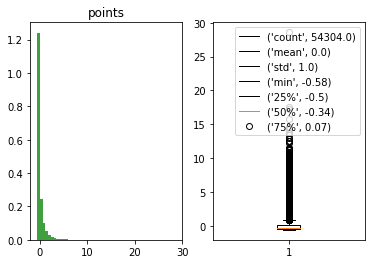

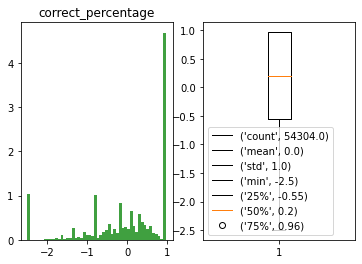

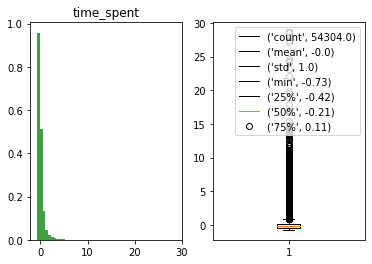

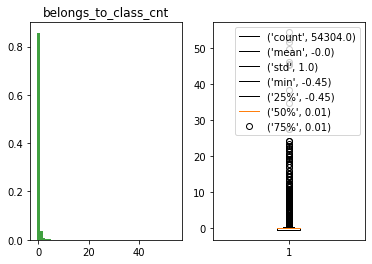

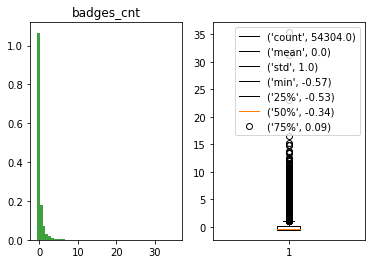

In [6]:
log("Preprocessing...")
user_features = U_features()
X: pd.DataFrame = preprocess_df(df=X, o_features=user_features)

## Splitting users

In [7]:
from cure import *


def split_users_by_grade(df):
    split1 = df[df["user_grade"] < 4]
    split2 = df[df["user_grade"] == 5]
    split3 = df[df["user_grade"] == 6]
    split4 = df[df["user_grade"] == 7]
    split5 = df[df["user_grade"] > 7]
    return [split1, split2, split3, split4, split5], ["split1", "split2", "split3", "split4", "split5"]


def cure_clustering(df: pd.DataFrame):
    data = df.drop(columns=["uuid"]).to_numpy()
    cure_repres = cure_representatives(data)
    cluster_labels = cure_classify(data, cure_repres)
    n_clusters = cluster_labels.max() + 1
    partition = lambda k: data[cluster_labels == k]
    similarities = [pairwise_distances(partition(k)) for k in range(n_clusters)]
    sim_users = [df["uuid"][cluster_labels == k] for k in range(n_clusters)]
    return cluster_labels, similarities, sim_users


USE_USER_USER_SIMILARITY = True
all_split_labels = []
all_split_similarities = []
all_split_sim_users = []

log("Splitting users...")
dfs, labels = split_users_by_grade(X)
del X

log('Cluster each instance of the split...')
for df, label in zip(dfs, labels):
    log("Getting clusters for {} users...".format(label))
    cluster_labels, similarities, sim_users = cure_clustering(df)
    all_split_labels.append(cluster_labels)
    all_split_similarities.append(similarities)
    all_split_sim_users.append(sim_users)

Splitting users...
Cluster each instance of the split...
Getting clusters for split1 users...
Getting clusters for split2 users...
Getting clusters for split3 users...
Getting clusters for split4 users...
Getting clusters for split5 users...


## Evaluate clusters

In [8]:
from sklearn.metrics import davies_bouldin_score


def evaluate_clusterings(combined):
    for df, split, labels in combined:
        df = df.drop(columns=["uuid", "first_login_date_TW"])
        data = df.to_numpy()
        log(f"Split: {split} | Davies-Bouldin score: ", davies_bouldin_score(data, labels))
        centroids = [np.average(data[labels == k], axis=0) for k in range(labels.max() + 1)]

        def interesting_columns(x: np.ndarray):
            return list(filter(lambda pair: pair[1] > 0.07, zip(df.columns, x)))

        c0 = centroids[0]
        log(f"Centroid differences (for {len(centroids)} clusters):")
        for i in range(1, min(4, len(centroids))):
            c1 = centroids[i]
            diff = sorted(diff, key=lambda p: p[1], reverse=True)[:3]
            log(diff)
        log('---')

log('Evaluate clusters in each split')
log('---')
evaluate_clusterings(zip(dfs, labels, all_split_labels))

Evaluate clusters in each split
---
Split: split1 | Davies-Bouldin score:  20.03571091366961
Centroid differences (for 5 clusters):
[('has_student_cnt', 0.32342093215925327), ('problems_attempted', 0.8307715974445031), ('gender_unspecified', 0.08641757932175942)]
[('has_teacher_cnt', 0.09073005467128503), ('has_student_cnt', 0.4670455544888016), ('problems_attempted', 12.31790686026934)]
---
Split: split2 | Davies-Bouldin score:  6.580712555735007
Centroid differences (for 5 clusters):
[('has_teacher_cnt', 0.27257021325254605), ('has_student_cnt', 0.4990898298518053), ('problems_attempted', 17.489206333761487)]
[('has_teacher_cnt', 0.32360384833214517), ('has_student_cnt', 0.4227762843304542), ('problems_attempted', 25.456553252496217)]
---
Split: split3 | Davies-Bouldin score:  13.720210919987778
Centroid differences (for 5 clusters):
[('has_teacher_cnt', 0.23592905889671378), ('problems_attempted', 8.869337180565038), ('avg_learning_stage', 0.32414916663208615)]
[('has_teacher_cnt', 

## Create utility matrix

In [ ]:
from recommender_system import *


def bind_labels_and_uuid(cluster_labels, sim_users):
    cluster_partitions = [cluster_labels[cluster_labels == i] for i in range(cluster_labels.max() + 1)]
    clusters = pd.DataFrame([np.hstack(cluster_partitions), np.hstack(sim_users)]).T
    clusters.columns = ["labels", "uuid"]
    return clusters


log("Binding clusters labels and uuids for all splits")
all_segment_clusters = [bind_labels_and_uuid(c_labels, s_users) for (c_labels, s_users) in
                        zip(all_split_labels, all_split_sim_users)]


def run_and_evaluate_recommender_system(clusters, df_pr, df_u, user_user_similarities, cluster_id=0,
                                        use_user_user_similarity=False):
    M, M_test, U1_ids, P1_ids = generate_utility_matrix_for_one_cluster(clusters=clusters, df_u_full=df_u,
                                                                        df_pr_full=df_pr, cluster_id=cluster_id)

    cluster_user_user_similarity = user_user_similarities[cluster_id]

    difficulties_for_all_users, errors_all = get_psedu_problem_difficulties(M, M_test, cluster_user_user_similarity,
                                                                            use_user_user_similarity)
    errors = [item[0] for sublist in errors_all for item in sublist if len(item) > 0]
    mean_abs_error = np.mean(errors)
    recommendation_difficulty_for_all_users, recommendation_idx_all = get_recommendation(difficulties_for_all_users)
    num_users = clusters.loc[clusters['labels'] == cluster_id].shape[0]
    print("Mean absolute error of difficulty was {} for cluster {} with {} users and use_similarrity={}".format(
        mean_abs_error, cluster_id, num_users, str(use_user_user_similarity)))
    return mean_abs_error, errors, recommendation_difficulty_for_all_users, recommendation_idx_all, np.mean(
        difficulties_for_all_users[difficulties_for_all_users > 0])


# Run all splits, and all clusters
mean_errors = []
for split_idx, clusters_ in enumerate(all_segment_clusters):
    df_u_split = dfs[split_idx]
    df_p_split = df_pr.loc[df_pr['uuid'].isin(df_u_split['uuid'])]
    similarities_ = all_split_similarities[split_idx]
    for cluster_idx in tqdm(range(len(similarities_)), desc="running cluster"):
        mean_abs_error, errors, recommendation_difficulty_for_all_users, recommendation_idx_all, mean_difficulty = run_and_evaluate_recommender_system(
            clusters_, df_p_split, df_u_split, similarities_, cluster_idx, USE_USER_USER_SIMILARITY)
        mean_errors.append(mean_abs_error)
        with open(f'{DATA_FOLDER}/evaluation/eval_mean_errors_5splits.txt', 'a') as f:
            f.write(
                "split_id: {},split_size: {}, cluster_id: {},cluster_u_size {}, n_errors: {}, mean_error: {}, mean_difficulty: {}, mean_recommendation_difficulty: {}\n".format(
                    split_idx, df_u_split.shape[0], cluster_idx, similarities_[cluster_idx].shape[0],
                    len(errors), np.round(mean_abs_error, 5), np.round(mean_difficulty, 5),
                    np.round(np.mean(recommendation_difficulty_for_all_users), 5)))
        with open(f'{DATA_FOLDER}/evaluation/eval_error_5splitss.txt', 'a') as f:
            f.write("split_id: {}, cluster_id: {}, errors {}\n".format(split_idx, cluster_idx, errors))
print("Mean absolute errors for the different splits {}".format(mean_errors))

Binding clusters labels and uuids for all splits


Func: construct_util_matrix():   3%|▎         | 95/2774 [01:35<2:16:00,  3.05s/it]


Func: construct_util_matrix():   7%|▋         | 193/2774 [02:30<18:28,  2.33it/s]


Func: construct_util_matrix():  11%|█         | 296/2774 [03:18<12:55,  3.19it/s]


Func: construct_util_matrix():  14%|█▍        | 398/2774 [04:59<53:02,  1.34s/it]


Func: construct_util_matrix():  18%|█▊        | 496/2774 [07:33<22:44,  1.67it/s]


Func: construct_util_matrix():  21%|██▏       | 592/2774 [10:28<1:35:08,  2.62s/it]


Func: construct_util_matrix():  25%|██▌       | 695/2774 [11:42<15:35,  2.22it/s]


Func: construct_util_matrix():  29%|██▊       | 791/2774 [14:10<2:05:48,  3.81s/it]


Func: construct_util_matrix():  32%|███▏      | 892/2774 [15:48<27:26,  1.14it/s]


Func: construct_util_matrix():  36%|███▌      | 988/2774 [17:46<37:05,  1.25s/it]


Func: construct_util_matrix():  39%|███▉      | 1089/2774 [19:24<18:49,  1.49it/s]


Func: construct_util_matrix():  43%|████▎     | 1188/2774 [20:33<10:05,  2.62it/s]


Func: construct_util_matrix():  46%|████▋     | 1288/2774 [22:18<09:02,  2.74it/s]


Func: construct_util_matrix():  50%|████▉     | 1385/2774 [23:51<39:37,  1.71s/it]


Func: construct_util_matrix():  53%|█████▎    | 1483/2774 [25:59<23:10,  1.08s/it]


Func: construct_util_matrix():  57%|█████▋    | 1579/2774 [28:38<12:19,  1.62it/s]


Func: construct_util_matrix():  61%|██████    | 1679/2774 [29:48<12:24,  1.47it/s]


Func: construct_util_matrix():  64%|██████▍   | 1777/2774 [31:16<22:11,  1.34s/it]


Func: construct_util_matrix():  68%|██████▊   | 1874/2774 [33:30<22:36,  1.51s/it]


Func: construct_util_matrix():  71%|███████   | 1976/2774 [34:43<11:37,  1.14it/s]


Func: construct_util_matrix():  75%|███████▍  | 2078/2774 [36:03<06:58,  1.66it/s]


Func: construct_util_matrix():  79%|███████▊  | 2182/2774 [37:27<10:48,  1.09s/it]


Func: construct_util_matrix():  82%|████████▏ | 2281/2774 [38:40<07:52,  1.04it/s]


Func: construct_util_matrix():  86%|████████▌ | 2382/2774 [40:18<02:56,  2.22it/s]


Func: construct_util_matrix():  89%|████████▉ | 2479/2774 [41:30<04:17,  1.15it/s]


Func: construct_util_matrix():  93%|█████████▎| 2574/2774 [43:04<04:11,  1.26s/it]


Func: construct_util_matrix():  96%|█████████▋| 2676/2774 [44:11<00:54,  1.81it/s]


Func: construct_util_matrix(): 100%|██████████| 2774/2774 [45:12<00:00,  1.02it/s]

Func: get_psedu_problem_difficulties():   0%|          | 3/2774 [00:03<48:02,  1.04s/it]


Func: get_psedu_problem_difficulties():   3%|▎         | 91/2774 [01:17<43:22,  1.03it/s]


Func: get_psedu_problem_difficulties():   6%|▋         | 178/2774 [02:26<28:32,  1.52it/s]


Func: get_psedu_problem_difficulties():  10%|▉         | 265/2774 [03:26<28:01,  1.49it/s]


Func: get_psedu_problem_difficulties():  13%|█▎        | 352/2774 [04:25<27:06,  1.49it/s]


Func: get_psedu_problem_difficulties():  16%|█▌        | 439/2774 [05:24<30:13,  1.29it/s]


Func: get_psedu_problem_difficulties():  19%|█▉        | 526/2774 [06:29<28:36,  1.31it/s]


Func: get_psedu_problem_difficulties():  22%|██▏       | 613/2774 [07:41<26:21,  1.37it/s]


Func: get_psedu_problem_difficulties():  25%|██▌       | 700/2774 [08:51<27:49,  1.24it/s]


Func: get_psedu_problem_difficulties():  28%|██▊       | 787/2774 [09:55<23:39,  1.40it/s]


Func: get_psedu_problem_difficulties():  32%|███▏      | 874/2774 [11:12<29:39,  1.07it/s]


Func: get_psedu_problem_difficulties():  35%|███▍      | 961/2774 [12:35<31:29,  1.04s/it]


Func: get_psedu_problem_difficulties():  38%|███▊      | 1047/2774 [13:45<22:51,  1.26it/s]


Func: get_psedu_problem_difficulties():  41%|████      | 1133/2774 [14:54<21:34,  1.27it/s]


Func: get_psedu_problem_difficulties():  44%|████▍     | 1219/2774 [16:02<21:15,  1.22it/s]


Func: get_psedu_problem_difficulties():  47%|████▋     | 1305/2774 [17:09<18:38,  1.31it/s]


Func: get_psedu_problem_difficulties():  50%|█████     | 1391/2774 [18:17<18:11,  1.27it/s]


Func: get_psedu_problem_difficulties():  53%|█████▎    | 1477/2774 [19:28<16:32,  1.31it/s]


Func: get_psedu_problem_difficulties():  56%|█████▋    | 1563/2774 [20:39<16:31,  1.22it/s]


Func: get_psedu_problem_difficulties():  59%|█████▉    | 1649/2774 [21:51<16:11,  1.16it/s]


Func: get_psedu_problem_difficulties():  63%|██████▎   | 1735/2774 [23:07<13:13,  1.31it/s]


Func: get_psedu_problem_difficulties():  66%|██████▌   | 1821/2774 [24:19<12:29,  1.27it/s]


Func: get_psedu_problem_difficulties():  69%|██████▊   | 1907/2774 [25:27<12:25,  1.16it/s]


Func: get_psedu_problem_difficulties():  72%|███████▏  | 1993/2774 [26:48<10:39,  1.22it/s]


Func: get_psedu_problem_difficulties():  75%|███████▍  | 2079/2774 [27:59<09:56,  1.16it/s]


Func: get_psedu_problem_difficulties():  78%|███████▊  | 2165/2774 [29:07<07:57,  1.28it/s]


Func: get_psedu_problem_difficulties():  81%|████████  | 2251/2774 [30:18<06:49,  1.28it/s]


Func: get_psedu_problem_difficulties():  84%|████████▍ | 2337/2774 [31:31<05:41,  1.28it/s]


Func: get_psedu_problem_difficulties():  87%|████████▋ | 2423/2774 [32:44<04:54,  1.19it/s]


Func: get_psedu_problem_difficulties():  90%|█████████ | 2509/2774 [33:55<03:21,  1.31it/s]


Func: get_psedu_problem_difficulties():  94%|█████████▎| 2595/2774 [35:04<02:31,  1.18it/s]


Func: get_psedu_problem_difficulties():  97%|█████████▋| 2681/2774 [36:23<01:25,  1.09it/s]


Func: get_psedu_problem_difficulties(): 100%|█████████▉| 2767/2774 [37:37<00:05,  1.19it/s]


Func: get_psedu_problem_difficulties(): 100%|██████████| 2774/2774 [37:43<00:00,  1.23it/s]


Mean absolute error of difficulty was 0.10985518800883853 for cluster 0 with 2774 users and use_similarrity=True


Func: construct_util_matrix():  15%|█▌        | 120/778 [00:32<04:59,  2.20it/s]


Func: construct_util_matrix():  33%|███▎      | 256/778 [01:08<01:41,  5.15it/s]


Func: construct_util_matrix():  51%|█████     | 396/778 [01:46<03:34,  1.78it/s]


Func: construct_util_matrix():  68%|██████▊   | 529/778 [03:12<02:00,  2.07it/s]


Func: construct_util_matrix():  85%|████████▍ | 659/778 [04:03<01:22,  1.45it/s]


Func: construct_util_matrix():  99%|█████████▊| 767/778 [06:15<00:04,  2.71it/s]


Func: construct_util_matrix(): 100%|██████████| 778/778 [06:20<00:00,  2.05it/s]

Func: get_psedu_problem_difficulties():  20%|██        | 157/778 [00:13<00:55, 11.29it/s]


Func: get_psedu_problem_difficulties():  42%|████▏     | 328/778 [00:29<00:41, 10.86it/s]


Func: get_psedu_problem_difficulties():  64%|██████▍   | 500/778 [00:45<00:24, 11.52it/s]


Func: get_psedu_problem_difficulties():  86%|████████▌ | 670/778 [01:01<00:09, 11.58it/s]


running cluster:  40%|████      | 2/5 [1:30:44<1:56:07, 2322.59s/it]

Mean absolute error of difficulty was 0.09027920405436232 for cluster 1 with 778 users and use_similarrity=True



Func: construct_util_matrix():   8%|▊         | 103/1369 [01:07<18:36,  1.13it/s]


Func: construct_util_matrix():  15%|█▌        | 212/1369 [02:45<35:53,  1.86s/it]


Func: construct_util_matrix():  24%|██▍       | 328/1369 [04:04<10:21,  1.67it/s]


Func: construct_util_matrix():  33%|███▎      | 449/1369 [04:47<05:24,  2.83it/s]


Func: construct_util_matrix():  41%|████      | 556/1369 [05:29<02:50,  4.76it/s]


Func: construct_util_matrix():  49%|████▉     | 674/1369 [06:13<02:48,  4.11it/s]


Func: construct_util_matrix():  60%|██████    | 828/1369 [06:43<00:56,  9.55it/s]


Func: construct_util_matrix():  71%|███████▏  | 976/1369 [07:08<01:24,  4.65it/s]


Func: construct_util_matrix():  81%|████████  | 1109/1369 [07:36<00:41,  6.32it/s]


Func: construct_util_matrix():  92%|█████████▏| 1260/1369 [07:57<00:10, 10.18it/s]


Func: construct_util_matrix(): 100%|██████████| 1369/1369 [08:10<00:00,  2.79it/s]

Func: get_psedu_problem_difficulties():   3%|▎         | 36/1369 [00:07<04:38,  4.78it/s]


Func: get_psedu_problem_difficulties():   9%|▉         | 123/1369 [00:26<04:34,  4.54it/s]


Func: get_psedu_problem_difficulties():  15%|█▌        | 210/1369 [00:45<03:58,  4.85it/s]


Func: get_psedu_problem_difficulties():  22%|██▏       | 297/1369 [01:04<03:44,  4.77it/s]


Func: get_psedu_problem_difficulties():  28%|██▊       | 384/1369 [01:22<03:09,  5.21it/s]


Func: get_psedu_problem_difficulties():  34%|███▍      | 471/1369 [01:39<02:51,  5.24it/s]


Func: get_psedu_problem_difficulties():  41%|████      | 558/1369 [01:56<02:51,  4.72it/s]


Func: get_psedu_problem_difficulties():  47%|████▋     | 645/1369 [02:14<02:30,  4.82it/s]


Func: get_psedu_problem_difficulties():  53%|█████▎    | 732/1369 [02:33<02:56,  3.61it/s]


Func: get_psedu_problem_difficulties():  60%|█████▉    | 819/1369 [02:52<02:19,  3.95it/s]


Func: get_psedu_problem_difficulties():  66%|██████▌   | 906/1369 [03:11<01:29,  5.20it/s]


Func: get_psedu_problem_difficulties():  73%|███████▎  | 993/1369 [03:28<01:15,  4.99it/s]


Func: get_psedu_problem_difficulties():  79%|███████▉  | 1079/1369 [03:45<00:58,  4.97it/s]


Func: get_psedu_problem_difficulties():  85%|████████▌ | 1165/1369 [04:04<00:49,  4.09it/s]


Func: get_psedu_problem_difficulties():  91%|█████████▏| 1251/1369 [04:22<00:24,  4.83it/s]


Func: get_psedu_problem_difficulties():  98%|█████████▊| 1337/1369 [04:39<00:06,  5.06it/s]


running cluster:  60%|██████    | 3/5 [1:43:43<53:55, 1617.89s/it]  

Mean absolute error of difficulty was 0.10468785168231319 for cluster 2 with 1369 users and use_similarrity=True



Func: construct_util_matrix():  11%|█         | 164/1471 [00:25<01:31, 14.32it/s]


Func: construct_util_matrix():  26%|██▌       | 381/1471 [00:46<01:54,  9.54it/s]


Func: construct_util_matrix():  39%|███▉      | 578/1471 [01:10<01:24, 10.58it/s]


Func: construct_util_matrix():  54%|█████▍    | 792/1471 [01:43<02:18,  4.92it/s]


Func: construct_util_matrix():  62%|██████▏   | 917/1471 [02:40<05:45,  1.60it/s]


Func: construct_util_matrix():  72%|███████▏  | 1054/1471 [03:21<00:42,  9.87it/s]


Func: construct_util_matrix():  82%|████████▏ | 1213/1471 [03:53<01:49,  2.36it/s]


Func: construct_util_matrix():  95%|█████████▍| 1391/1471 [04:18<00:05, 15.64it/s]


Func: construct_util_matrix(): 100%|██████████| 1471/1471 [04:31<00:00,  5.42it/s]

Func: get_psedu_problem_difficulties():   3%|▎         | 45/1471 [00:08<04:02,  5.87it/s]


Func: get_psedu_problem_difficulties():   9%|▉         | 132/1471 [00:24<03:38,  6.13it/s]


Func: get_psedu_problem_difficulties():  15%|█▍        | 219/1471 [00:40<03:32,  5.90it/s]


Func: get_psedu_problem_difficulties():  21%|██        | 306/1471 [00:56<03:10,  6.12it/s]


Func: get_psedu_problem_difficulties():  27%|██▋       | 393/1471 [01:11<02:59,  6.01it/s]


Func: get_psedu_problem_difficulties():  33%|███▎      | 480/1471 [01:26<03:10,  5.20it/s]


Func: get_psedu_problem_difficulties():  39%|███▊      | 567/1471 [01:45<03:04,  4.90it/s]


Func: get_psedu_problem_difficulties():  44%|████▍     | 654/1471 [02:02<02:32,  5.34it/s]


Func: get_psedu_problem_difficulties():  50%|█████     | 741/1471 [02:19<02:19,  5.24it/s]


Func: get_psedu_problem_difficulties():  56%|█████▋    | 828/1471 [02:37<02:06,  5.10it/s]


Func: get_psedu_problem_difficulties():  62%|██████▏   | 915/1471 [02:55<01:58,  4.69it/s]


Func: get_psedu_problem_difficulties():  68%|██████▊   | 1002/1471 [03:13<01:29,  5.26it/s]


Func: get_psedu_problem_difficulties():  74%|███████▍  | 1088/1471 [03:31<01:27,  4.37it/s]


Func: get_psedu_problem_difficulties():  80%|███████▉  | 1174/1471 [03:48<00:52,  5.69it/s]


Func: get_psedu_problem_difficulties():  86%|████████▌ | 1260/1471 [04:04<00:49,  4.26it/s]


Func: get_psedu_problem_difficulties():  92%|█████████▏| 1346/1471 [04:20<00:24,  5.19it/s]


Func: get_psedu_problem_difficulties():  97%|█████████▋| 1432/1471 [04:36<00:06,  5.67it/s]


running cluster:  80%|████████  | 4/5 [1:52:59<19:58, 1198.93s/it]

Mean absolute error of difficulty was 0.10438842296962332 for cluster 3 with 1471 users and use_similarrity=True



Func: construct_util_matrix():   5%|▌         | 109/2152 [00:40<09:54,  3.44it/s]


Func: construct_util_matrix():  10%|▉         | 214/2152 [01:26<12:55,  2.50it/s]


Func: construct_util_matrix():  15%|█▍        | 316/2152 [02:25<10:15,  2.98it/s]


Func: construct_util_matrix():  20%|█▉        | 428/2152 [03:01<13:30,  2.13it/s]


Func: construct_util_matrix():  25%|██▍       | 536/2152 [03:48<12:28,  2.16it/s]


Func: construct_util_matrix():  30%|██▉       | 642/2152 [05:13<14:14,  1.77it/s]


Func: construct_util_matrix():  34%|███▍      | 741/2152 [06:05<13:03,  1.80it/s]


Func: construct_util_matrix():  39%|███▉      | 846/2152 [07:19<34:26,  1.58s/it]


Func: construct_util_matrix():  44%|████▍     | 952/2152 [09:32<1:20:30,  4.03s/it]


Func: construct_util_matrix():  49%|████▉     | 1054/2152 [11:27<19:20,  1.06s/it]


Func: construct_util_matrix():  54%|█████▍    | 1159/2152 [12:53<18:30,  1.12s/it]


Func: construct_util_matrix():  59%|█████▉    | 1279/2152 [13:57<03:53,  3.74it/s]


Func: construct_util_matrix():  65%|██████▍   | 1395/2152 [14:50<02:23,  5.28it/s]


Func: construct_util_matrix():  70%|███████   | 1512/2152 [15:34<02:11,  4.88it/s]


Func: construct_util_matrix():  76%|███████▌  | 1634/2152 [16:11<07:05,  1.22it/s]


Func: construct_util_matrix():  81%|████████▏ | 1753/2152 [17:09<01:27,  4.57it/s]


Func: construct_util_matrix():  87%|████████▋ | 1864/2152 [18:25<01:17,  3.72it/s]


Func: construct_util_matrix():  92%|█████████▏| 1971/2152 [19:07<02:17,  1.32it/s]


Func: construct_util_matrix():  97%|█████████▋| 2089/2152 [20:09<00:21,  2.95it/s]


Func: construct_util_matrix(): 100%|██████████| 2152/2152 [20:46<00:00,  1.73it/s]

Func: get_psedu_problem_difficulties():   2%|▏         | 36/2152 [00:16<15:51,  2.22it/s]


Func: get_psedu_problem_difficulties():   6%|▌         | 123/2152 [00:56<15:10,  2.23it/s]


Func: get_psedu_problem_difficulties():  10%|▉         | 210/2152 [01:34<15:45,  2.05it/s]


Func: get_psedu_problem_difficulties():  14%|█▍        | 297/2152 [02:17<16:40,  1.85it/s]


Func: get_psedu_problem_difficulties():  18%|█▊        | 384/2152 [03:08<17:13,  1.71it/s]


Func: get_psedu_problem_difficulties():  22%|██▏       | 471/2152 [03:54<13:47,  2.03it/s]


Func: get_psedu_problem_difficulties():  26%|██▌       | 558/2152 [04:39<14:00,  1.90it/s]


Func: get_psedu_problem_difficulties():  30%|██▉       | 645/2152 [05:26<14:27,  1.74it/s]


Func: get_psedu_problem_difficulties():  32%|███▏      | 695/2152 [05:51<11:15,  2.16it/s]